**Importing** **Modules**

In [13]:
# importing modules
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from dateutil import parser
lemma = WordNetLemmatizer()
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Lists to store all the data**

In [14]:
# reviews list
reviews = []

# starts list
stars = []

# date list
date = []

# country list
country = []

**Data Collection**

In [15]:
# Data Collection

for i in range(1, 30):
    page = requests.get(f'https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/').text
    soup = BeautifulSoup(page, 'lxml')

    # collecting all the reviews
    for item in soup.find_all('div', class_='text_content'):
        reviews.append(item.text)

    # collecting all the ratings
    for item in soup.find_all('div', class_='rating-10', attrs={'itemprop': 'reviewRating'}):
        stars.append(item.span.text)

    # collecting all the dates
    for item in soup.find_all('time'):
        date.append(item.text)

    # collecting all the countries
    for item in soup.find_all('h3'):
        country.append(item.span.next_sibling.text.strip().replace('(', '').replace(')', ''))

# creating the data frame
df = pd.DataFrame({'reviews': reviews, 'stars': stars, 'date': date, 'country': country})


**Data Manipulation**

In [16]:
# Data Manipulation

# exporting data into csv format
cwd = os.getcwd()
df.to_csv(cwd+'/BA_reviews.csv')


# creating a new column for Trip verification
df['verified'] = df.reviews.str.contains('Trip Verified')

# cleaning reviews
reviews_data = df.reviews.str.replace('✅ Trip Verified |', '').replace('Not Verified |', '')

# corpus list to collect cleaned data
corpus =[]

# loop through each review, remove punctuations, small case it, join it and add it to corpus
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = [lemma.lemmatize(word) for word in rev if word not in set(stopwords.words("english"))]
    rev = " ".join(rev)
    corpus.append(rev)

# creating a new column corpus and adding corpus list to it
df['corpus'] = corpus

# converting the date to datetime format
df['date'] = df['date'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d'))
df['date'] = pd.to_datetime(df['date'])

# exporting the data to csv after cleaning
df.to_csv(cwd + "/cleaned-BA-reviews.csv")

<ipython-input-16-80a27197f298>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_data = df.reviews.str.replace('✅ Trip Verified |', '').replace('Not Verified |', '')


**Data Visualisation**

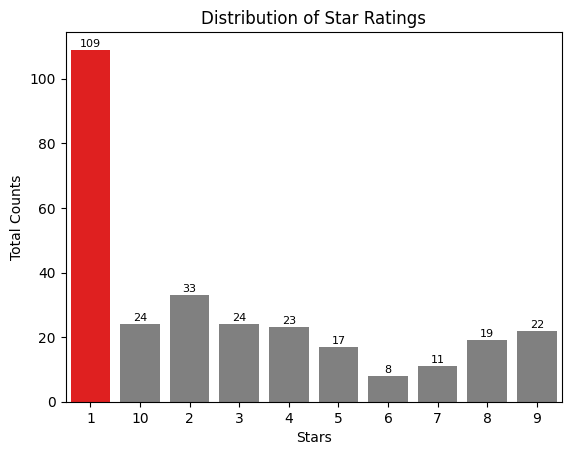

In [17]:
# Data Visualisation

# total counts for each rating
df_ratings = df['stars'].value_counts().sort_index().to_frame().reset_index()
df_ratings.columns = ['Stars', 'total_counts']
pct_values = (df_ratings['total_counts'] / df_ratings['total_counts'].sum() * 100).tolist()

# Create a color palette for the bars
clrs = ['grey' if (x < max(pct_values)) else 'red' for x in pct_values]

# Create the vertical bar plot
ax = sns.barplot(x='Stars', y='total_counts', data=df_ratings, errwidth=0, palette=clrs)

# Add labels to the bars
for i, v in enumerate(df_ratings['total_counts']):
    ax.text(i, v + 1, str(v), ha='center', fontsize=8)

# Set the plot title and labels
ax.set_title('Distribution of Star Ratings')
ax.set_xlabel('Stars')
ax.set_ylabel('Total Counts')

# Show the plot
plt.show()